In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# 📁 Étape 2 : Chargement des données

In [ ]:
# Chemin vers les fichiers (à adapter selon ton dossier local)
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/Deep learning/projet à rendre"  # ex. "/kaggle/input/siim-isic-melanoma-classification"
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv") # Corrected path to the CSV file
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "jpeg/train") # Corrected path to the image directory

# Charger le fichier train.csv
df = pd.read_csv(TRAIN_CSV)

# Afficher les colonnes principales
print(df[['image_name', 'target', 'sex', 'age_approx', 'anatom_site_general_challenge']].head())

     image_name  target     sex  age_approx anatom_site_general_challenge
0  ISIC_2637011       0    male        45.0                     head/neck
1  ISIC_0015719       0  female        45.0               upper extremity
2  ISIC_0052212       0  female        50.0               lower extremity
3  ISIC_0068279       0  female        45.0                     head/neck
4  ISIC_0074268       0  female        55.0               upper extremity


# 📊 Étape 3 : Analyser la taille et le volume de données dans le dossier train

In [ ]:
import os
import humanize  # Pour formater la taille de manière lisible

train_img_dir = "/content/drive/MyDrive/Colab Notebooks/Deep learning/projet à rendre/jpeg/train"

# Initialisation
total_size = 0
num_files = 0

# Parcourir tous les fichiers du dossier
for root, dirs, files in os.walk(train_img_dir):
    for file in files:
        if file.lower().endswith(".jpg"):
            file_path = os.path.join(root, file)
            total_size += os.path.getsize(file_path)
            num_files += 1

# Affichage formaté
print("📷 Nombre total d'images :", num_files)
print("💾 Taille totale du dossier :", humanize.naturalsize(total_size))

📷 Nombre total d'images : 33126
💾 Taille totale du dossier : 25.8 GB


# Étape 4 : Partir avec 10% des données

In [ ]:
# Charger le CSV
df = pd.read_csv(TRAIN_CSV)

# Ajouter les chemins d'image
df['image_path'] = df['image_name'].apply(lambda x: os.path.join(TRAIN_IMG_DIR, f"{x}.jpg"))

# 🧪 Vérif rapide avant échantillonnage
print("Classe 0:", (df['target'] == 0).sum())
print("Classe 1:", (df['target'] == 1).sum())

# 🔁 Réduction équilibrée (ex: 300 de chaque classe)
N = 584  # choisis un nombre selon ta RAM (300~500 recommandé)
df_0 = df[df['target'] == 0].sample(n=N, random_state=42)
df_1 = df[df['target'] == 1].sample(n=N, random_state=42)

df_balanced = pd.concat([df_0, df_1]).sample(frac=1, random_state=42).reset_index(drop=True)

# ✅ Vérification
print(df_balanced['target'].value_counts())

Classe 0: 32542
Classe 1: 584
target
1    584
0    584
Name: count, dtype: int64


# Étape 5 – Split en train/validation

In [ ]:
from sklearn.model_selection import train_test_split

X = df_balanced['image_path']
y = df_balanced['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

train_df = pd.DataFrame({'image_path': X_train, 'target': y_train})
val_df = pd.DataFrame({'image_path': X_val, 'target': y_val})

In [ ]:
import os

# ✅ Vérifier les chemins valides dans chaque set
train_existing = train_df['image_path'].apply(os.path.exists).sum()
val_existing = val_df['image_path'].apply(os.path.exists).sum()

print(f"📁 Images d'entraînement valides : {train_existing} / {len(train_df)}")
print(f"📁 Images de validation valides : {val_existing} / {len(val_df)}")

📁 Images d'entraînement valides : 934 / 934
📁 Images de validation valides : 234 / 234


# 🌀 Étape 6 – Générateurs d’images

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2, rotation_range=10)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='target',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw'
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='target',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)

Found 934 validated image filenames.
Found 234 validated image filenames.


# 🧠 Étape 7 – définir et compiler le modèle

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # On fige la base

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# 🏋️ Étape 9 : Entraînement du modèle

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=3, restore_best_weights=True)

EPOCHS = 5  # ou + si tout fonctionne bien

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 875s 29s/step - AUC: 0.6610 - loss: 0.6414 - val_AUC: 0.8479 - val_loss: 0.4910
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step - AUC: 0.8293 - loss: 0.5105 - val_AUC: 0.8547 - val_loss: 0.5114
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - AUC: 0.8653 - loss: 0.4630 - val_AUC: 0.8498 - val_loss: 0.6151
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - AUC: 0.8569 - loss: 0.4743 - val_AUC: 0.8552 - val_loss: 0.4994


# 📊 Étape 10 – Évaluation du modèle

📊 Évaluation du modèle...
AUC sur validation: 0.8479
Perte sur validation: 0.4910
🎯 Précision: 0.7607 (76.07%)

📋 Rapport de classification:
              precision    recall  f1-score   support

    Classe 0     0.7699    0.7436    0.7565       117
    Classe 1     0.7521    0.7778    0.7647       117

    accuracy                         0.7607       234
   macro avg     0.7610    0.7607    0.7606       234
weighted avg     0.7610    0.7607    0.7606       234



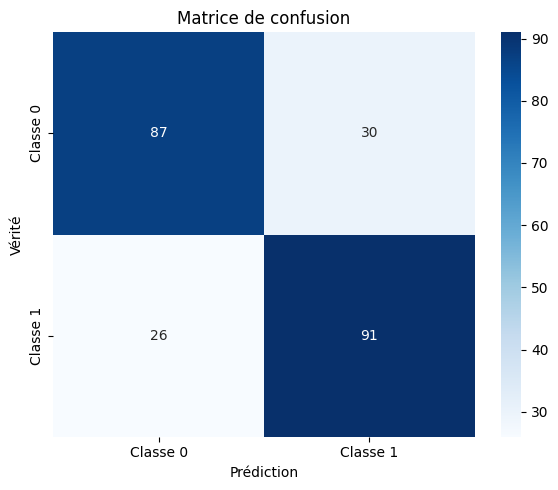

In [ ]:
# 📊 ÉVALUATION DÉTAILLÉE DU MODÈLE
print("📊 Évaluation du modèle...")

# Évaluation sur l'ensemble de validation
val_loss, val_auc = model.evaluate(val_gen, verbose=0)
print(f"AUC sur validation: {val_auc:.4f}")
print(f"Perte sur validation: {val_loss:.4f}")

# Prédictions pour analyse détaillée
val_gen.reset()
predictions = model.predict(val_gen, verbose=0).ravel()
y_pred_binary = (predictions > 0.5).astype(int)
y_true = val_df['target'].values  # Assure que ce sont des numpy arrays

# 🎯 Précision
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = accuracy_score(y_true, y_pred_binary)
print(f"🎯 Précision: {accuracy:.4f} ({accuracy*100:.2f}%)")

# 📋 Rapport de classification
print("\n📋 Rapport de classification:")
class_names = ['Classe 0', 'Classe 1']
print(classification_report(y_true, y_pred_binary, target_names=class_names, digits=4))

# 📌 Matrice de confusion
cm = confusion_matrix(y_true, y_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de confusion')
plt.xlabel('Prédiction')
plt.ylabel('Vérité')
plt.tight_layout()
plt.show()

# Etape 11 : Sauvegarde du modèle entrainé

In [ ]:
print("💾 Sauvegarde du modèle...")

# Sauvegarde complète du modèle
model.save('/content/drive/MyDrive/Colab Notebooks/Deep learning/projet à rendre/cancer_detection_model.keras') # Changed to .keras format
print("✅ Modèle sauvegardé : cancer_detection_model.keras")

# Sauvegarde des poids seulement
model.save_weights('/content/drive/MyDrive/Colab Notebooks/Deep learning/projet à rendre/cancer_model_weights.weights.h5') # Corrected filename
print("✅ Poids sauvegardés : cancer_model_weights.weights.h5")

💾 Sauvegarde du modèle...
✅ Modèle sauvegardé : cancer_detection_model.keras
✅ Poids sauvegardés : cancer_model_weights.weights.h5


# Etape 12 : VISUALISATION DES RÉSULTATS D'ENTRAÎNEMENT

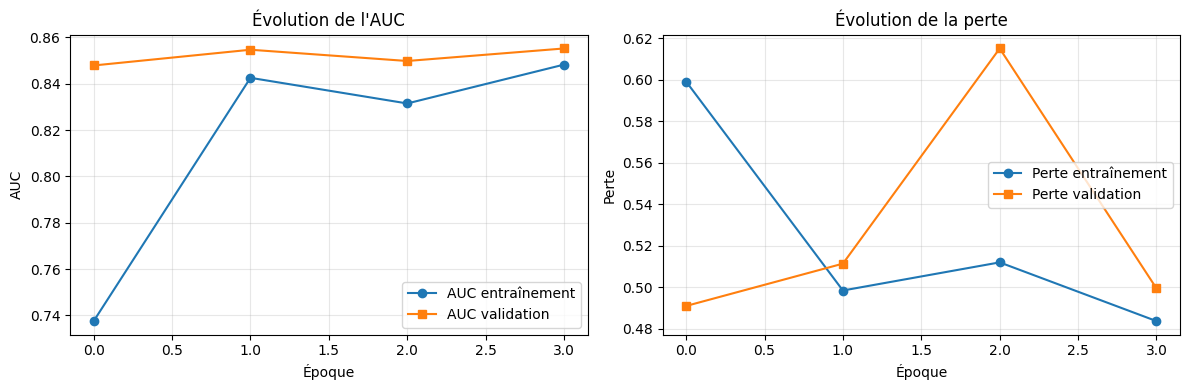

In [ ]:
import matplotlib.pyplot as plt

def plot_training_results(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Graphique AUC
    ax1.plot(history.history['AUC'], label='AUC entraînement', marker='o')
    ax1.plot(history.history['val_AUC'], label='AUC validation', marker='s')
    ax1.set_title('Évolution de l\'AUC')
    ax1.set_xlabel('Époque')
    ax1.set_ylabel('AUC')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Graphique perte
    ax2.plot(history.history['loss'], label='Perte entraînement', marker='o')
    ax2.plot(history.history['val_loss'], label='Perte validation', marker='s')
    ax2.set_title('Évolution de la perte')
    ax2.set_xlabel('Époque')
    ax2.set_ylabel('Perte')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_results(history)

# Etape 13 : TEST SUR QUELQUES IMAGES

In [ ]:
def predict_image(model, img_path, class_names):
    """Prédire une seule image"""
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array, verbose=0)[0][0]
    predicted_class = class_names[1] if prediction > 0.5 else class_names[0]
    confidence = prediction if prediction > 0.5 else 1 - prediction

    return predicted_class, confidence, prediction

# Tester sur quelques images
print("\n🔍 Tests sur des images d'exemple:")
# class_names = list(val_gen.class_indices.keys()) # Removed this line
class_names = ['Classe 0', 'Classe 1'] # Manually defined class names

# Prendre quelques images de test
import os
sample_images = []
data_dir = "/content/drive/MyDrive/Colab Notebooks/Deep learning/projet à rendre/jpeg"

# Assuming there are 'train' and 'test' subdirectories within data_dir, and classes are within them
# Adjust this logic based on your actual directory structure
for class_folder in ['train']: # Modify if you have a 'test' folder or different structure
    class_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_path):
        files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        # Take a few random samples from the available files
        import random
        sample_files = random.sample(files, min(2, len(files))) # Take up to 2 random files
        for file in sample_files:
             sample_images.append(os.path.join(class_path, file))


for img_path in sample_images[:6]:  # Maximum 6 images
    try:
        predicted_class, confidence, raw_pred = predict_image(model, img_path, class_names)
        # Attempt to infer true class from the image path if possible
        # This part might need adjustment depending on your file naming or directory structure
        true_class = "Unknown" # Default if cannot infer
        if "benign" in img_path.lower(): # Example: if your paths contain class names
             true_class = class_names[0]
        elif "malignant" in img_path.lower():
             true_class = class_names[1]
        # You might need a more robust way to get the true class based on your data

        print(f"Image: {os.path.basename(img_path)}")
        print(f"Classe réelle: {true_class}") # This might be inaccurate without true labels
        print(f"Prédiction: {predicted_class} (Confiance: {confidence:.2f})")
        print(f"Score brut: {raw_pred:.4f}")
        print("-" * 50)
    except Exception as e:
        print(f"Erreur avec {img_path}: {e}")


🔍 Tests sur des images d'exemple:
Image: ISIC_7944732.jpg
Classe réelle: Unknown
Prédiction: Classe 0 (Confiance: 0.53)
Score brut: 0.4718
--------------------------------------------------
Image: ISIC_8357420.jpg
Classe réelle: Unknown
Prédiction: Classe 1 (Confiance: 0.56)
Score brut: 0.5556
--------------------------------------------------


# RÉSUMÉ FINAL

In [ ]:
print("\n" + "="*60)
print("🎯 RÉSUMÉ DU PROJET")
print("="*60)
print(f"Objectif: Atteindre au moins 75% de précision")
print(f"AUC obtenue: {val_auc:.4f}")
print(f"Précision obtenue: {accuracy*100:.2f}%")

if accuracy >= 0.75:
    print("✅ OBJECTIF ATTEINT! Félicitations!")
elif val_auc >= 0.75:
    print("✅ TRÈS BON RÉSULTAT! AUC > 0.75")
else:
    print("⚠️ Objectif pas encore atteint")
    print("💡 Suggestions:")
    print("   - Augmenter le nombre d'époques")
    print("   - Essayer différents hyperparamètres")
    print("   - Ajouter plus de données")

print(f"Nombre d'époques: {len(history.history['loss'])}")
print(f"Meilleure AUC validation: {max(history.history['val_AUC']):.4f}")
print("="*60)


🎯 RÉSUMÉ DU PROJET
Objectif: Atteindre au moins 75% de précision
AUC obtenue: 0.8479
Précision obtenue: 76.07%
✅ OBJECTIF ATTEINT! Félicitations!
Nombre d'époques: 4
Meilleure AUC validation: 0.8552


# COMMENT RECHARGER LE MODÈLE

In [ ]:
print("\n📝 Pour recharger le modèle plus tard:")
print("loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/cancer_detection_model.h5')")
print("\n🎉 Projet terminé avec succès!")